# Brain Tumor Detection from MRI images (using EfficientNet V2.0)

### The aim of this project was to apply Deep Learning approaches to achieve the best possible detection and classification of different tumor types from 2D MRI images from human brains

## Get and Load Dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=da6787ce-12e0-4ef9-a678-1fd2f8c6c7dc
To: /home/constructor/gammer_exercises/DL_group_challenge/brain_tumor.zip
100%|████████████████████████████████████████| 156M/156M [00:13<00:00, 11.5MB/s]


In [ ]:
!pip install unzip

In [ ]:
#!unzip brain_tumor.zip

/bin/bash: line 1: unzip: command not found


In [ ]:
ls -l

total 152496
-rw-r--r-- 1 constructor constructor        50 Apr  4 10:17 Brain_Tumor_Detector_Helper.ipynb:Zone.Identifier
-rw-r--r-- 1 constructor constructor    348977 Apr  4 10:22 Brain_Tumor_Detector_gammer.ipynb
drwxr-xr-x 6 constructor constructor      4096 Apr  4 10:24 Testing/
drwxr-xr-x 6 constructor constructor      4096 Apr  4 10:29 Training/
-rw-r--r-- 1 constructor constructor 155791278 Apr  4 10:20 brain_tumor.zip


In [ ]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

[sudo] password for constructor: 


In [ ]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

/bin/bash: line 1: tree: command not found


In [ ]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

/bin/bash: line 1: tree: command not found


## Load Dependencies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

2024-04-05 11:14:03.190123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 11:14:03.216679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 11:14:03.216701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 11:14:03.217427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 11:14:03.221997: I tensorflow/core/platform/cpu_feature_guar

TF Version: 2.15.0


## Utility functions to create dataset generators

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [ ]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2024-04-05 11:01:07.666567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:01:07.691159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:01:07.691221: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:01:07.694262: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:01:07.694308: I external/local_xla/xla/stream_executor

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


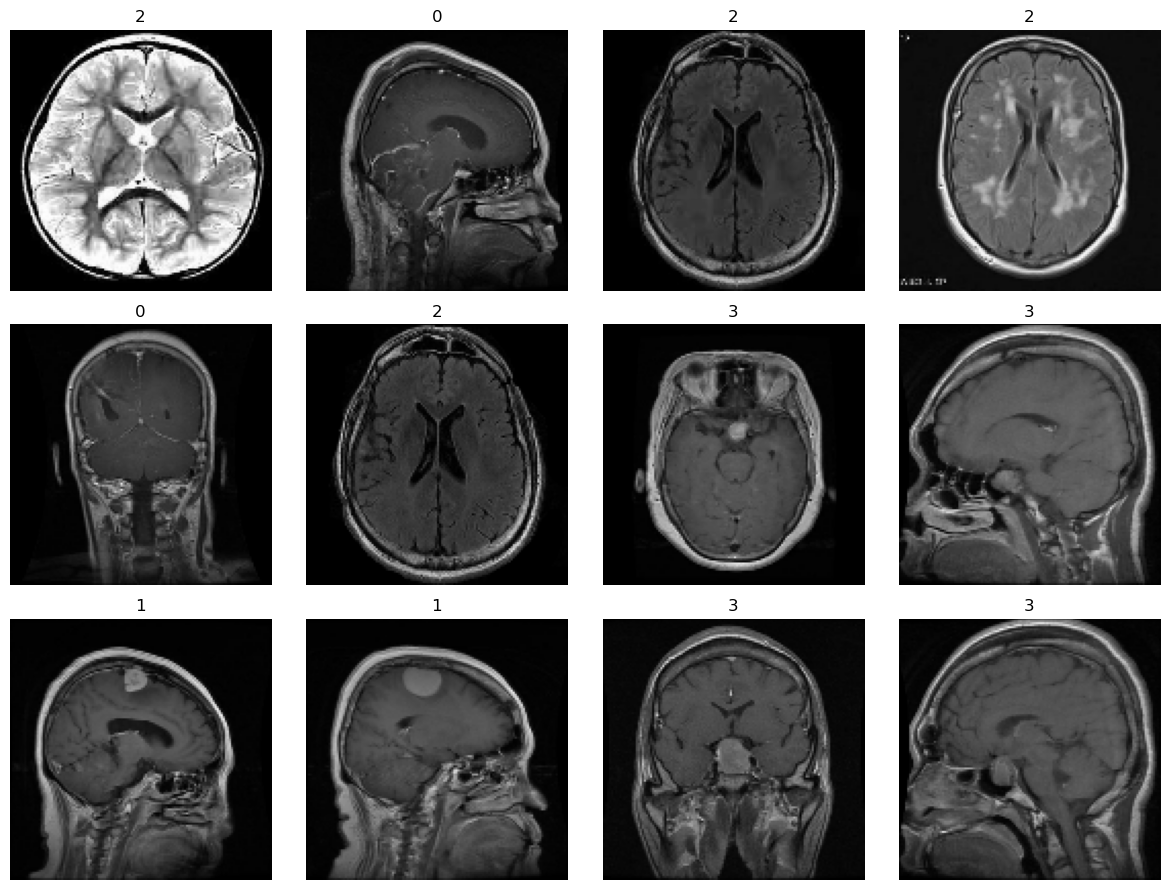

In [ ]:
plt.figure(figsize=(12, 9))

for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## Create a simple baseline CNN model

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (8, 8), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (16, 16), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        524352    
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [ ]:
model.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [ ]:
%%time
history = model.fit(
                    train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    )

Epoch 1/20


2024-04-05 10:43:38.752582: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-05 10:43:39.509357: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-05 10:43:40.485964: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2173f979b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 10:43:40.485993: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6
2024-04-05 10:43:40.489891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712306620.553920   74917 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 [==============================] - 9s 25ms/step - loss: 3.8028 - sparse_categorical_accuracy: 0.5418 - val_loss: 0.6536 - val_sparse_categorical_accuracy: 0.7443
Epoch 2/20
143/143 [==============================] - 2s 16ms/step - loss: 0.7270 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.5213 - val_sparse_categorical_accuracy: 0.8135
Epoch 3/20
143/143 [==============================] - 2s 15ms/step - loss: 0.5505 - sparse_categorical_accuracy: 0.7923 - val_loss: 0.4870 - val_sparse_categorical_accuracy: 0.8363
Epoch 4/20
143/143 [==============================] - 2s 15ms/step - loss: 0.4499 - sparse_categorical_accuracy: 0.8411 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.8520
Epoch 5/20
143/143 [==============================] - 2s 15ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.8711 - val_loss: 0.3751 - val_sparse_categorical_accuracy: 0.8722
Epoch 6/20
143/143 [==============================] - 2s 15ms/step - loss: 0.2800 - sparse_categorical_acc

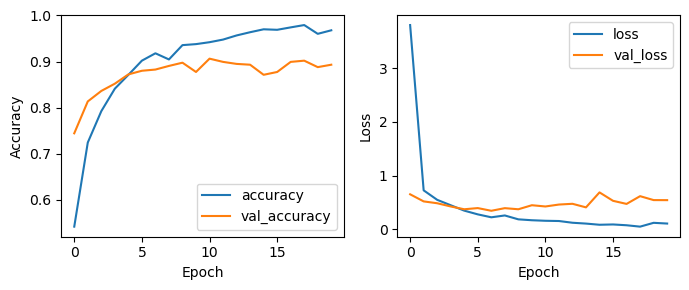

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history.history['loss'], label='loss')
ax[1].plot(history.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.savefig("./plots/basic_CNN.png", dpi=300, format='png')
plt.show()


In [ ]:
y_true, y_pred = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:00<00:04,  2.34it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:00<00:02,  3.51it/s]

4/4 [==============================] - 0s 19ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:00<00:01,  4.59it/s]

4/4 [==============================] - 0s 18ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:00<00:01,  5.40it/s]

4/4 [==============================] - 0s 18ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:01<00:01,  5.98it/s]

4/4 [==============================] - 0s 18ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:01<00:00,  6.43it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:01<00:00,  8.46it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:01<00:00,  9.83it/s]

1/1 [==============================] - 0s 307ms/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.05it/s]


In [ ]:
y_pred_class = np.argmax(y_pred,1)
y_pred_class.shape

(1311,)

In [ ]:
print(classification_report(y_true, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.89      0.82      0.86       300
  meningioma       0.79      0.84      0.81       306
     notumor       0.97      0.98      0.97       405
   pituitary       0.93      0.94      0.94       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311



In [ ]:
report = classification_report(y_true, y_pred_class, target_names=classes, output_dict=True)
df_classification_report = pd.DataFrame(report).T
df_classification_report.to_csv("./plots/basic_CNN.csv", index=True)
df_classification_report

,precision,recall,f1-score,support
glioma,0.894545,0.820000,0.855652,300.000000
meningioma,0.790123,0.836601,0.812698,306.000000
notumor,0.965770,0.975309,0.970516,405.000000
pituitary,0.933993,0.943333,0.938640,300.000000
accuracy,0.900076,0.900076,0.900076,0.900076
macro avg,0.896108,0.893811,0.894377,1311.000000
weighted avg,0.901202,0.900076,0.900101,1311.000000


In [ ]:
print(confusion_matrix(y_true, y_pred_class))

[[246  49   0   5]
 [ 22 256  14  14]
 [  1   8 395   1]
 [  6  11   0 283]]


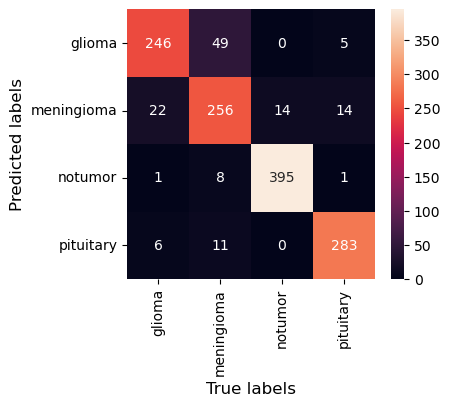

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_class),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.savefig("./plots/basic_CNN_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

## Use EfficientNet Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model_name = 'efficient_netV2S'

In [ ]:
model_EN = tf.keras.applications.EfficientNetV2S(
                                                    include_top=False,
                                                    weights='imagenet',
                                                    input_tensor=None,
                                                    input_shape=IMG_SHAPE,
                                                    pooling=None,
                                                    classes=4,
                                                    classifier_activation='softmax',
                                                    include_preprocessing=True
                                                )

In [ ]:
#model_EN.summary()

In [ ]:
for layer in model_EN.layers[-10:]:
  print(layer.name)

block6o_se_reduce
block6o_se_expand
block6o_se_excite
block6o_project_conv
block6o_project_bn
block6o_drop
block6o_add
top_conv
top_bn
top_activation


In [ ]:
last_conv_layer = model_EN.get_layer('top_activation')

conv_model = Model(inputs=model_EN.input,
                       outputs=last_conv_layer.output)

In [ ]:
num_classes = 4

In [ ]:
new_model = Sequential()
new_model.add(conv_model)
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(layers.Dense(32, activation='relu'))
new_model.add(layers.Dropout(0.2))
new_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 1280)        20331360  
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 20372484 (77.71 MB)
Trainable params: 20218612 (77.13 MB)
Non-trainable params: 153872 (601.06 KB)
_________

In [ ]:
new_model.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [ ]:
%%time
# Define the checkpoint callback
checkpoint = ModelCheckpoint("best_model_EN.h5", monitor='val_loss', save_best_only=True, mode='min')

history_1 = new_model.fit(
                            train_ds,
                            epochs = 20,
                            validation_data = val_ds,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-05 10:50:28.824681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/model/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-05 10:50:33.217937: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-05 10:50:33.941006: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-05 10:50:35.471996: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd15cfdce80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 10:50:35.472026: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6
2024-04-05 10:50:35.475791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling ML

143/143 [==============================] - ETA: 0s - loss: 0.4150 - sparse_categorical_accuracy: 0.8626

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 87s 212ms/step - loss: 0.4150 - sparse_categorical_accuracy: 0.8626 - val_loss: 0.2312 - val_sparse_categorical_accuracy: 0.9124
Epoch 2/20
143/143 [==============================] - 26s 179ms/step - loss: 0.1642 - sparse_categorical_accuracy: 0.9453 - val_loss: 0.0950 - val_sparse_categorical_accuracy: 0.9702
Epoch 3/20
143/143 [==============================] - 25s 174ms/step - loss: 0.1272 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.3111 - val_sparse_categorical_accuracy: 0.9247
Epoch 4/20
143/143 [==============================] - 25s 173ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9615
Epoch 5/20
143/143 [==============================] - 26s 180ms/step - loss: 0.0724 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.0696 - val_sparse_categorical_accuracy: 0.9737
Epoch 6/20
143/143 [==============================] - 26s 179ms/step - loss: 0.0405 - sparse_cat

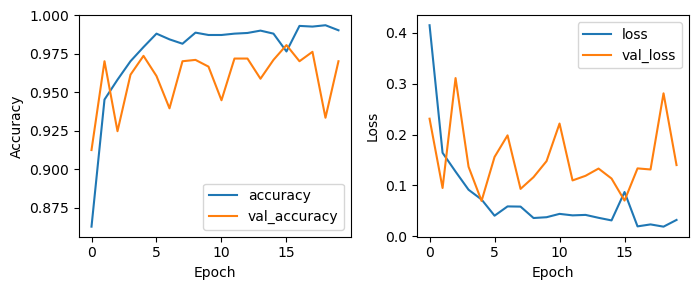

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_1.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_1.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_1.history['loss'], label='loss')
ax[1].plot(history_1.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.savefig("./plots/basic_EN.png", dpi=300, format='png')
plt.show()

In [ ]:
y_true_1, y_pred_1 = eval_model_on_test(new_model)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 118ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:03<00:36,  3.66s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:14,  1.63s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:04<00:07,  1.02it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:04<00:04,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:04<00:03,  1.99it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:04<00:01,  2.50it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  2.98it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:05<00:00,  3.42it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:05<00:00,  3.81it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:05<00:00,  4.12it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.24it/s]


In [ ]:
y_pred_class_1 = np.argmax(y_pred_1,1)

In [ ]:
print(classification_report(y_true_1, y_pred_class_1, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.97      0.97      0.97       300
  meningioma       0.96      0.95      0.96       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
report_EN = classification_report(y_true_1, y_pred_class_1, target_names=classes, output_dict=True)
df_cr_EN = pd.DataFrame(report_EN).T
df_cr_EN.to_csv("./plots/basic_EN.csv", index=True)
df_cr_EN

,precision,recall,f1-score,support
glioma,0.973244,0.970000,0.971619,300.000000
meningioma,0.963455,0.947712,0.955519,306.000000
notumor,0.987715,0.992593,0.990148,405.000000
pituitary,0.983553,0.996667,0.990066,300.000000
accuracy,0.977879,0.977879,0.977879,0.977879
macro avg,0.976992,0.976743,0.976838,1311.000000
weighted avg,0.977789,0.977879,0.977807,1311.000000


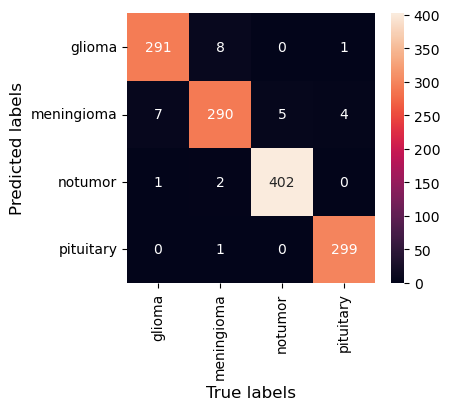

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_1, y_pred_class_1),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.savefig("./plots/basic_EN_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
print(confusion_matrix(y_true_1, y_pred_class_1))

[[291   8   0   1]
 [  7 290   5   4]
 [  1   2 402   0]
 [  0   1   0 299]]


## Balance Class weights and use Efficient Net

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
class_weight_dict = {0: 1.0925, 1: 1.071078431372549, 2: 0.8092592592592592, 3: 1.0925}

In [ ]:
new_model_bal = Sequential()
new_model_bal.add(conv_model)
new_model_bal.add(tf.keras.layers.GlobalAveragePooling2D())
new_model_bal.add(layers.Dense(32, activation='relu'))
new_model_bal.add(layers.Dropout(0.2))
new_model_bal.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
new_model_bal.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [ ]:
new_model_bal.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 1280)        20331360  
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 20372484 (77.71 MB)
Trainable params: 20218612 (77.13 MB)
Non-trainable params: 153872 (601.06 KB)
_______

In [ ]:
%%time

# Define the checkpoint callback
checkpoint = ModelCheckpoint("best_model_EN_bal.h5", monitor='val_loss', save_best_only=True, mode='min')

class_weight_dict = {0: 1.0925, 1: 1.071078431372549, 2: 0.8092592592592592, 3: 1.0925}

history_2 = new_model_bal.fit(
                            train_ds,
                            epochs = 20,
                            validation_data = val_ds,
                            class_weight = class_weight_dict,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-05 11:02:20.107776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/model/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-05 11:02:24.686654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-05 11:02:25.454835: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-05 11:02:27.071231: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe7658630a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 11:02:27.071268: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6
2024-04-05 11:02:27.075654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling 

143/143 [==============================] - ETA: 0s - loss: 0.4441 - sparse_categorical_accuracy: 0.8484

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 91s 216ms/step - loss: 0.4441 - sparse_categorical_accuracy: 0.8484 - val_loss: 0.2387 - val_sparse_categorical_accuracy: 0.9378
Epoch 2/20
143/143 [==============================] - 26s 180ms/step - loss: 0.2178 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.1461 - val_sparse_categorical_accuracy: 0.9597
Epoch 3/20
143/143 [==============================] - 25s 173ms/step - loss: 0.1342 - sparse_categorical_accuracy: 0.9589 - val_loss: 0.5542 - val_sparse_categorical_accuracy: 0.8932
Epoch 4/20
143/143 [==============================] - 25s 174ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.3273 - val_sparse_categorical_accuracy: 0.9046
Epoch 5/20
143/143 [==============================] - 26s 181ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.1347 - val_sparse_categorical_accuracy: 0.9641
Epoch 6/20
143/143 [==============================] - 25s 175ms/step - loss: 0.0617 - sparse_cat

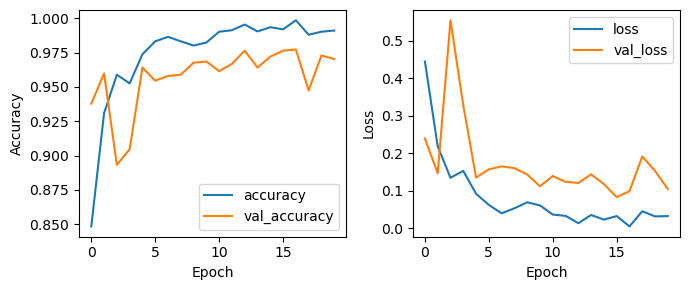

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_2.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_2.history['loss'], label='loss')
ax[1].plot(history_2.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.savefig("./plots/basic_EN_bal.png", dpi=300, format='png')
plt.show()

In [ ]:
y_true_bal, y_pred_bal = eval_model_on_test(new_model_bal)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 116ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:02<00:29,  2.92s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:11,  1.32s/it]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:03<00:06,  1.23it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:03<00:03,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:03<00:02,  2.29it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:03<00:01,  2.80it/s]

4/4 [==============================] - 0s 41ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  3.24it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:04<00:00,  3.61it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:04<00:00,  3.96it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:04<00:00,  4.25it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.35it/s]


In [ ]:
y_pred_class_bal = np.argmax(y_pred_bal,1)
print(classification_report(y_true_bal, y_pred_class_bal, target_names=classes))

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       300
  meningioma       0.96      0.96      0.96       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
report_bal = classification_report(y_true_bal, y_pred_class_bal, target_names=classes, output_dict=True)
df_cr_bal = pd.DataFrame(report_bal).T
df_cr_bal.to_csv("./plots/basic_EN.csv", index=True)
df_cr_bal

,precision,recall,f1-score,support
glioma,0.996540,0.960000,0.977929,300.000000
meningioma,0.960784,0.960784,0.960784,306.000000
notumor,0.980630,1.000000,0.990220,405.000000
pituitary,0.986799,0.996667,0.991708,300.000000
accuracy,0.980931,0.980931,0.980931,0.980931
macro avg,0.981188,0.979363,0.980160,1311.000000
weighted avg,0.981050,0.980931,0.980877,1311.000000


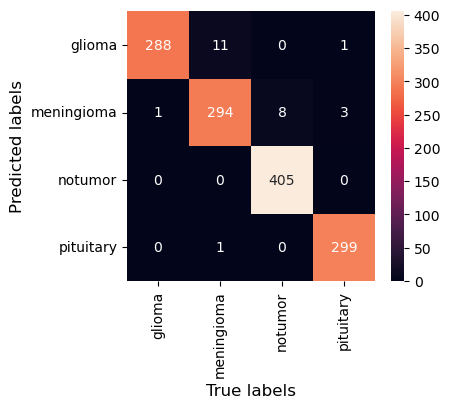

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_bal, y_pred_class_bal),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.savefig("./plots/basic_EN_bal_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

## Apply data augmentation before training the elasticnet model

In [ ]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 16
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def prepare_train_and_val_datasets_w_aug():
    train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds_aug = (train_ds_aug.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.4), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=25))

    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds_aug, val_ds

In [ ]:
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [ ]:
train_ds_aug, val_ds = prepare_train_and_val_datasets_w_aug()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2024-04-05 11:18:10.569612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:18:10.592799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:18:10.592854: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:18:10.595428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 11:18:10.595460: I external/local_xla/xla/stream_executor

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [ ]:
new_model_aug = Sequential()
new_model_aug.add(conv_model)
new_model_aug.add(tf.keras.layers.GlobalAveragePooling2D())
new_model_aug.add(layers.Dense(32, activation='relu'))
new_model_aug.add(layers.Dropout(0.2))
new_model_aug.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
new_model_aug.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [ ]:
%%time

# Define the checkpoint callback
checkpoint = ModelCheckpoint("best_model_EN_aug.h5", monitor='val_loss', save_best_only=True, mode='min')

class_weight_dict = {0: 1.0925, 1: 1.071078431372549, 2: 0.8092592592592592, 3: 1.0925}

history_3 = new_model_aug.fit(
                            train_ds_aug,
                            epochs = 20,
                            validation_data = val_ds,
                            class_weight = class_weight_dict,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-05 11:19:29.978386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/model/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-05 11:19:35.447352: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-05 11:19:36.192597: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-05 11:19:37.605863: I external/local_xla/xla/service/service.cc:168] XLA service 0x29ff96c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-05 11:19:37.605893: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6
2024-04-05 11:19:37.610299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR c

286/286 [==============================] - ETA: 0s - loss: 0.5204 - sparse_categorical_accuracy: 0.8289

/home/constructor/anaconda3/envs/DLG/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 98s 136ms/step - loss: 0.5204 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.3561 - val_sparse_categorical_accuracy: 0.8634
Epoch 2/20
286/286 [==============================] - 35s 117ms/step - loss: 0.2784 - sparse_categorical_accuracy: 0.9109 - val_loss: 0.1350 - val_sparse_categorical_accuracy: 0.9536
Epoch 3/20
286/286 [==============================] - 33s 112ms/step - loss: 0.2001 - sparse_categorical_accuracy: 0.9405 - val_loss: 0.1566 - val_sparse_categorical_accuracy: 0.9475
Epoch 4/20
286/286 [==============================] - 35s 120ms/step - loss: 0.1576 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.1345 - val_sparse_categorical_accuracy: 0.9597
Epoch 5/20
286/286 [==============================] - 39s 132ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.1041 - val_sparse_categorical_accuracy: 0.9658
Epoch 6/20
286/286 [==============================] - 39s 131ms/step - loss: 0.1197 - sparse_cat

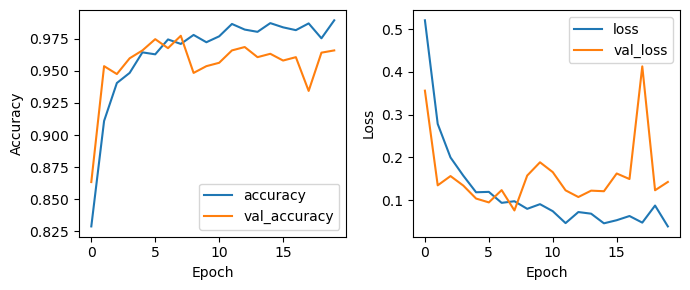

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_3.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_3.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_3.history['loss'], label='loss')
ax[1].plot(history_3.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.savefig("./plots/basic_EN_aug.png", dpi=300, format='png')
plt.show()

In [ ]:
y_true_aug, y_pred_aug = eval_model_on_test(new_model_aug)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 4s 34ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:04<00:41,  4.17s/it]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:04<00:16,  1.84s/it]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:04<00:08,  1.09s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:04<00:05,  1.36it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:04<00:03,  1.84it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:05<00:02,  2.35it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:05<00:01,  2.85it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:05<00:00,  3.32it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:05<00:00,  3.73it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:05<00:00,  4.07it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.19it/s]


In [ ]:
y_pred_class_aug = np.argmax(y_pred_aug,1)
print(classification_report(y_true_aug, y_pred_class_aug, target_names=classes))

              precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       300
  meningioma       0.93      0.96      0.95       306
     notumor       0.97      0.99      0.98       405
   pituitary       1.00      0.96      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
report_aug = classification_report(y_true_aug, y_pred_class_aug, target_names=classes, output_dict=True)
df_cr_aug = pd.DataFrame(report_aug).T
df_cr_aug.to_csv("./plots/basic_EN_aug.csv", index=True)
df_cr_aug

,precision,recall,f1-score,support
glioma,0.975862,0.943333,0.959322,300.000000
meningioma,0.933544,0.964052,0.948553,306.000000
notumor,0.966265,0.990123,0.978049,405.000000
pituitary,0.996552,0.963333,0.979661,300.000000
accuracy,0.967201,0.967201,0.967201,0.967201
macro avg,0.968056,0.965211,0.966396,1311.000000
weighted avg,0.967754,0.967201,0.967248,1311.000000


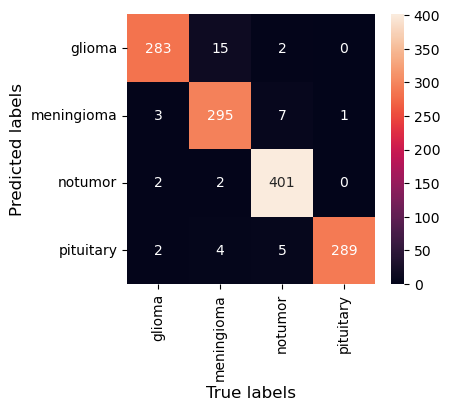

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_aug, y_pred_class_aug),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.savefig("./plots/basic_EN_aug_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
#new_model_aug.save_weights('./model_weights/new_model_aug')

In [ ]:
new_model_man = Sequential()
new_model_man.add(conv_model)
new_model_man.add(tf.keras.layers.GlobalAveragePooling2D())
new_model_man.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
new_model_man.compile(
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['sparse_categorical_accuracy']
              )

In [ ]:
class_weight_man = [2, 2, 0.5, 1]
class_weight_dict_manual = { i : class_weight_man[i] for i in range(0, len(class_weight_man) ) }
class_weight_dict_manual

In [ ]:
%%time
# Define the checkpoint callback
checkpoint = ModelCheckpoint("best_model_EN_man.h5", monitor='val_loss', save_best_only=True, mode='min')

history_4 = new_model_man.fit(
                            train_ds_aug,
                            epochs = 20,
                            validation_data = val_ds,
                            class_weight = class_weight_dict_manual,
                            callbacks=[checkpoint]
                            )

Epoch 1/20


2024-04-04 15:44:58.336747: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/model_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - ETA: 0s - loss: 0.0408 - sparse_categorical_accuracy: 0.9939

2024-04-04 15:45:47.776141: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 83s 189ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1223 - val_sparse_categorical_accuracy: 0.9702
Epoch 2/20
143/143 [==============================] - ETA: 0s - loss: 0.0309 - sparse_categorical_accuracy: 0.9939

2024-04-04 15:46:13.663947: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0309 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1333 - val_sparse_categorical_accuracy: 0.9641
Epoch 3/20
143/143 [==============================] - ETA: 0s - loss: 0.0216 - sparse_categorical_accuracy: 0.9952

2024-04-04 15:46:39.688609: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.1187 - val_sparse_categorical_accuracy: 0.9755
Epoch 4/20
143/143 [==============================] - ETA: 0s - loss: 0.0064 - sparse_categorical_accuracy: 0.9985

2024-04-04 15:47:05.650256: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0833 - val_sparse_categorical_accuracy: 0.9816
Epoch 5/20
143/143 [==============================] - ETA: 0s - loss: 0.0120 - sparse_categorical_accuracy: 0.9980

2024-04-04 15:47:31.837977: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0120 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1058 - val_sparse_categorical_accuracy: 0.9807
Epoch 6/20
143/143 [==============================] - ETA: 0s - loss: 0.0064 - sparse_categorical_accuracy: 0.9989

2024-04-04 15:47:57.536085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.1073 - val_sparse_categorical_accuracy: 0.9816
Epoch 7/20
143/143 [==============================] - ETA: 0s - loss: 0.0089 - sparse_categorical_accuracy: 0.9982

2024-04-04 15:48:23.189076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0952 - val_sparse_categorical_accuracy: 0.9825
Epoch 8/20
143/143 [==============================] - ETA: 0s - loss: 0.0025 - sparse_categorical_accuracy: 0.9991

2024-04-04 15:48:48.805315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0025 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1022 - val_sparse_categorical_accuracy: 0.9825
Epoch 9/20
143/143 [==============================] - ETA: 0s - loss: 0.0062 - sparse_categorical_accuracy: 0.9978

2024-04-04 15:49:14.454973: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.1396 - val_sparse_categorical_accuracy: 0.9790
Epoch 10/20
143/143 [==============================] - ETA: 0s - loss: 0.0326 - sparse_categorical_accuracy: 0.9939

2024-04-04 15:49:40.031443: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9939 - val_loss: 0.1028 - val_sparse_categorical_accuracy: 0.9807
Epoch 11/20
143/143 [==============================] - ETA: 0s - loss: 0.0222 - sparse_categorical_accuracy: 0.9947

2024-04-04 15:50:05.668700: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0222 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.1060 - val_sparse_categorical_accuracy: 0.9799
Epoch 12/20
143/143 [==============================] - ETA: 0s - loss: 0.0123 - sparse_categorical_accuracy: 0.9978

2024-04-04 15:50:31.681255: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0123 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0919 - val_sparse_categorical_accuracy: 0.9790
Epoch 13/20
143/143 [==============================] - ETA: 0s - loss: 0.0064 - sparse_categorical_accuracy: 0.9985

2024-04-04 15:50:57.917697: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1148 - val_sparse_categorical_accuracy: 0.9764
Epoch 14/20
143/143 [==============================] - ETA: 0s - loss: 0.0017 - sparse_categorical_accuracy: 0.9996

2024-04-04 15:51:23.886083: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.1034 - val_sparse_categorical_accuracy: 0.9816
Epoch 15/20
143/143 [==============================] - ETA: 0s - loss: 0.0029 - sparse_categorical_accuracy: 0.9991

2024-04-04 15:51:49.606733: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0029 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1019 - val_sparse_categorical_accuracy: 0.9842
Epoch 16/20
143/143 [==============================] - ETA: 0s - loss: 0.0140 - sparse_categorical_accuracy: 0.9958

2024-04-04 15:52:15.670551: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 173ms/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.1172 - val_sparse_categorical_accuracy: 0.9729
Epoch 17/20
143/143 [==============================] - ETA: 0s - loss: 0.0456 - sparse_categorical_accuracy: 0.9895

2024-04-04 15:52:41.458478: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 171ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.1338 - val_sparse_categorical_accuracy: 0.9694
Epoch 18/20
143/143 [==============================] - ETA: 0s - loss: 0.0520 - sparse_categorical_accuracy: 0.9884

2024-04-04 15:53:07.112574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 170ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.1084 - val_sparse_categorical_accuracy: 0.9755
Epoch 19/20
143/143 [==============================] - ETA: 0s - loss: 0.0187 - sparse_categorical_accuracy: 0.9943

2024-04-04 15:53:33.060557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 172ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9943 - val_loss: 0.1204 - val_sparse_categorical_accuracy: 0.9755
Epoch 20/20
143/143 [==============================] - ETA: 0s - loss: 0.0189 - sparse_categorical_accuracy: 0.9958

2024-04-04 15:53:59.327084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/143 [==============================] - 26s 176ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0713 - val_sparse_categorical_accuracy: 0.9816
CPU times: user 10min 9s, sys: 1min 57s, total: 12min 6s
Wall time: 9min 34s


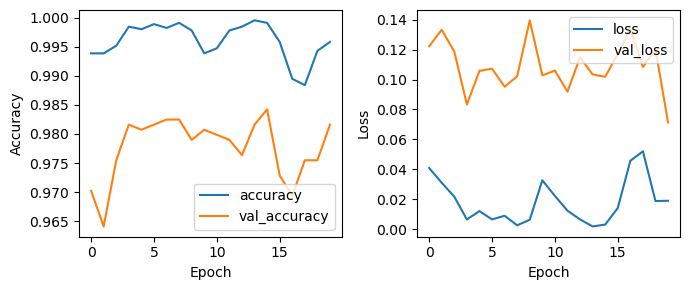

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_4.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_4.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_4.history['loss'], label='loss')
ax[1].plot(history_4.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
plt.show()

In [ ]:
y_true_man, y_pred_man = eval_model_on_test(new_model_man)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 96ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:02<00:29,  2.90s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:11,  1.32s/it]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:03<00:06,  1.24it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:03<00:03,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:03<00:02,  2.28it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:03<00:01,  2.81it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  3.27it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:04<00:00,  3.70it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:04<00:00,  4.04it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:04<00:00,  4.31it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.50it/s]


In [ ]:
y_pred_class_man = np.argmax(y_pred_man,1)
print(classification_report(y_true_man, y_pred_class_man, target_names=class_names))

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.95      0.99      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



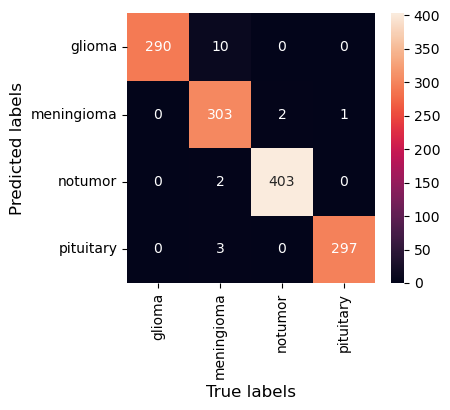

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_man, y_pred_class_man),
            annot=True,
            fmt=".0f",
            xticklabels=class_names,
            yticklabels=class_names
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.show()

## Train best model with all training data a final time

In [ ]:
def prepare_only_train_w_aug():
    train_ds_only = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=16,
    )


    train_ds_only = (train_ds_only.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.4), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=25))

    return train_ds_only

In [ ]:
train_ds_only = prepare_only_train_w_aug()

Found 5712 files belonging to 4 classes.


In [ ]:
%%time
checkpoint = ModelCheckpoint("best_model_EN_final.h5", monitor='loss', save_best_only=True, mode='min')

class_weight_dict = {0: 1.0925, 1: 1.071078431372549, 2: 0.8092592592592592, 3: 1.0925}

history_5 = new_model_aug.fit(
                            train_ds_only,
                            epochs = 30,
                            validation_data = val_ds,
                            class_weight = class_weight_dict,
                            callbacks=[checkpoint]
                            )

Epoch 1/30
357/357 [==============================] - 42s 114ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0079 - val_sparse_categorical_accuracy: 0.9974
Epoch 2/30
357/357 [==============================] - 44s 119ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.0056 - val_sparse_categorical_accuracy: 0.9974
Epoch 3/30
357/357 [==============================] - 46s 124ms/step - loss: 0.0076 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.9982
Epoch 4/30
357/357 [==============================] - 45s 121ms/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0242 - val_sparse_categorical_accuracy: 0.9921
Epoch 5/30
357/357 [==============================] - 48s 128ms/step - loss: 0.0289 - sparse_categorical_accuracy: 0.9911 - val_loss: 0.0063 - val_sparse_categorical_accuracy: 0.9974
Epoch 6/30
357/357 [==============================] - 49s 134ms/step - loss: 0.0111 -

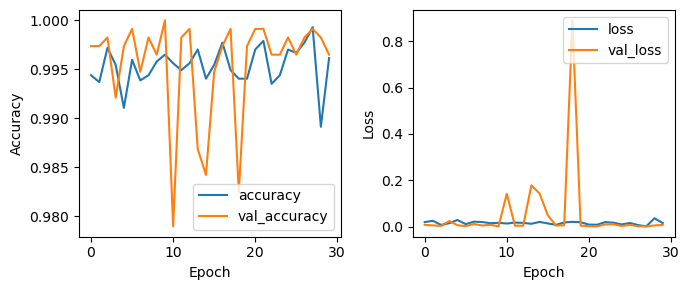

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(7,3))

ax[0].plot(history_5.history['sparse_categorical_accuracy'], label='accuracy')
ax[0].plot(history_5.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right');

ax[1].plot(history_5.history['loss'], label='loss')
ax[1].plot(history_5.history['val_loss'], label = 'val_loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right');

fig.tight_layout()
#plt.savefig("./plots/basic_EN_aug_final.png", dpi=300, format='png')
plt.show()

In [ ]:
y_true_final, y_pred_final = eval_model_on_test(new_model_aug)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 144ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:00<00:06,  1.49it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:00<00:03,  2.53it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:01<00:02,  3.23it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:01<00:01,  3.73it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:01<00:01,  4.10it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:01<00:01,  4.27it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:01<00:00,  4.43it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:02<00:00,  4.48it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:02<00:00,  4.54it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:02<00:00,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.17it/s]


In [ ]:
y_pred_class_final = np.argmax(y_pred_final,1)
print(classification_report(y_true_final, y_pred_class_final, target_names=classes))

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.97      0.98      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
report_final = classification_report(y_true_final, y_pred_class_final, target_names=classes, output_dict=True)
df_cr_final = pd.DataFrame(report_final).T
#df_cr_final.to_csv("./plots/basic_EN_final.csv", index=True)
df_cr_final

,precision,recall,f1-score,support
glioma,0.996587,0.973333,0.984823,300.000000
meningioma,0.974026,0.980392,0.977199,306.000000
notumor,0.985401,1.000000,0.992647,405.000000
pituitary,0.996656,0.993333,0.994992,300.000000
accuracy,0.987796,0.987796,0.987796,0.987796
macro avg,0.988167,0.986765,0.987415,1311.000000
weighted avg,0.987881,0.987796,0.987787,1311.000000


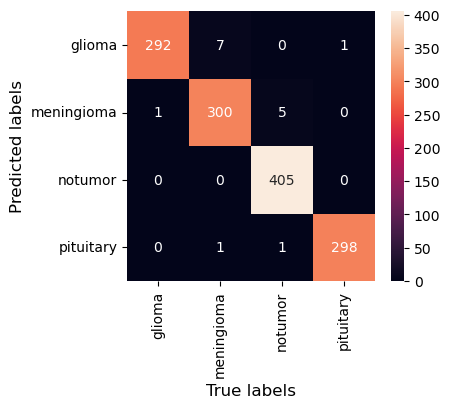

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_final, y_pred_class_final),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
#plt.savefig("./plots/basic_EN_aug_final_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

### Save best model as h5 file

In [ ]:
new_model_aug.save_weights('./model_weights/new_model_final')

## Load best model and run predictions

In [ ]:
model_best_one = keras.models.load_model('new_model_final.h5')

In [ ]:
model_best_one.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4, 4, 1280)        20331360  
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_31 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 20336484 (77.58 MB)
Trainable params: 20182612 (76.99 MB)
Non-trainable params: 153872 (601.06 KB)
_________________________________________________________________


In [ ]:
y_true_best, y_pred_best = eval_model_on_test(model_best_one)

Found 1311 files belonging to 4 classes.


Predicting on Test Data:   0%|                                                                   | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 3s 110ms/step


Predicting on Test Data:   9%|█████▎                                                     | 1/11 [00:02<00:29,  2.93s/it]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  18%|██████████▋                                                | 2/11 [00:03<00:11,  1.33s/it]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  27%|████████████████                                           | 3/11 [00:03<00:06,  1.23it/s]

4/4 [==============================] - 0s 35ms/step


Predicting on Test Data:  36%|█████████████████████▍                                     | 4/11 [00:03<00:04,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  45%|██████████████████████████▊                                | 5/11 [00:03<00:02,  2.28it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  55%|████████████████████████████████▏                          | 6/11 [00:03<00:01,  2.80it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  64%|█████████████████████████████████████▌                     | 7/11 [00:04<00:01,  3.27it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  73%|██████████████████████████████████████████▉                | 8/11 [00:04<00:00,  3.66it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  82%|████████████████████████████████████████████████▎          | 9/11 [00:04<00:00,  3.99it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  91%|████████████████████████████████████████████████████▋     | 10/11 [00:04<00:00,  4.23it/s]

1/1 [==============================] - 3s 3s/step


Predicting on Test Data: 100%|██████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.35it/s]


In [ ]:
y_pred_class_best = np.argmax(y_pred_best,1)
print(classification_report(y_true_best, y_pred_class_best, target_names=classes))

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [ ]:
report_best = classification_report(y_true_best, y_pred_class_best, target_names=classes, output_dict=True)
df_cr_best = pd.DataFrame(report_best).T
df_cr_best.to_csv("./plots/basic_EN_best.csv", index=True)
df_cr_best

,precision,recall,f1-score,support
glioma,1.000000,0.970000,0.984772,300.000000
meningioma,0.971246,0.993464,0.982229,306.000000
notumor,0.997537,1.000000,0.998767,405.000000
pituitary,0.996678,1.000000,0.998336,300.000000
accuracy,0.991609,0.991609,0.991609,0.991609
macro avg,0.991365,0.990866,0.991026,1311.000000
weighted avg,0.991767,0.991609,0.991606,1311.000000


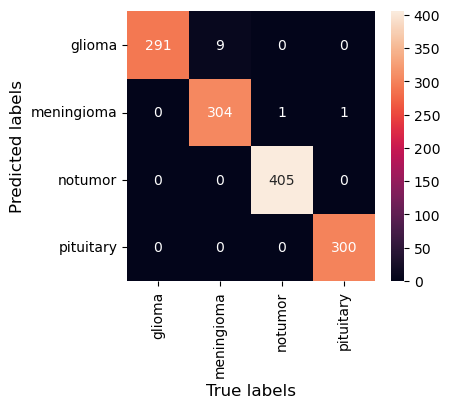

In [ ]:
plt.subplots(figsize=(4,3.5))
ax = sns.heatmap(confusion_matrix(y_true_best, y_pred_class_best),
            annot=True,
            fmt=".0f",
            xticklabels=classes,
            yticklabels=classes
            );
#ax.set_xticklabels(class_names, rotation=90, size="10")
ax.set_xlabel('True labels', size='12')
ax.set_ylabel('Predicted labels', size='12')
plt.savefig("./plots/basic_EN_aug_best_CM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
acc_dict = {"InceptionV3": 77.0, "baselineCNN": 93.0, "ResNet50": 95.0, "EN_aug_bal": 96.7, "EN_base": 97.8, "EN_bal": 98.0, "EN_aug_bal_RT": 99.2}

In [ ]:
df_acc = pd.DataFrame(list(acc_dict.items()), columns=['Model', 'Accuracy'])

In [ ]:
df_acc

,Model,Accuracy
0,InceptionV3,77.0
1,baselineCNN,93.0
2,ResNet50,95.0
3,EN_aug_bal,96.7
4,EN_base,97.8
5,EN_bal,98.0
6,EN_aug_bal_RT,99.2


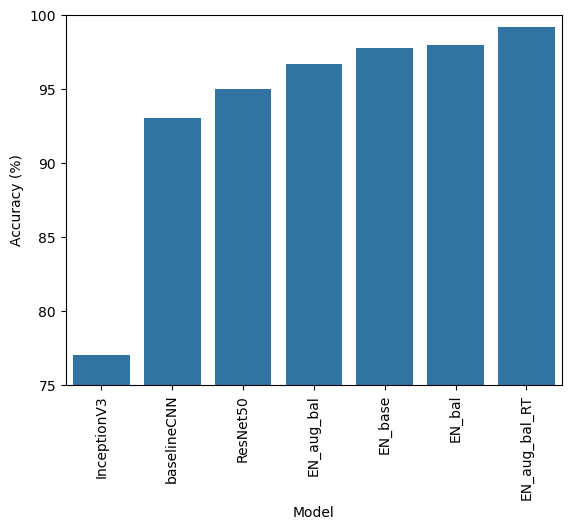

In [ ]:
sns.barplot(x='Model', y='Accuracy', data=df_acc)
#plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=90)
plt.ylim(75,100)
plt.savefig("./plots/accuracy_barplot.png", dpi=300, format='png', bbox_inches='tight')
plt.show()